# Assay and run directory

In [8]:
assay_name = "drd2_cleaned"
dataset_name = "datasets/drd2_cleaned.csv"
rundir = "results/lstm_hc/drd2_cleaned/"
pca_components = 50
kmeans = True

# Analysis

In [9]:
import os
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from sklearn.decomposition import PCA
from utils import compute_internal_jaccard_diversity, data_split, ClusterFps, ecfp4, find_cluster, max_tanimoto_similarity, indexes_identical_fps, average_tanimoto_similarity, tanimoto_similarities, calculateScore, Descriptors, quantitative_analysis

import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import seaborn as sns 
import matplotlib
from sklearn.cluster import KMeans

from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Crippen import MolLogP, MolMR


font = {'family' : 'normal',
        'size'   : 35}

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 35,
    'text.usetex': False,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
def data_split(dataset):
    """
    Args:
        chid: which assay to use:
        external_file:
    Returns:
        clfs: Dictionary of fitted classifiers
        aucs: Dictionary of AUCs
        balance: Two numbers showing the number of actives in split 1 / split 2
        df1: data in split 1
        df2: data in split 2
    """
    # read data and calculate ecfp fingerprints
    
    df = pd.read_csv(dataset)
    df['label'] = df['value']>7.5
    df['ecfp'] = ecfp4(df.smiles)
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=0)
    X1 = np.array(list(df_train['ecfp']))
    X2 = np.array(list(df_test['ecfp']))
    y1 = np.array(list(df_train['label']))
    y2 = np.array(list(df_test['label']))
      
    
    # train classifiers and store them in dictionary
    
    clf = RandomForestClassifier( 
        n_estimators=100, n_jobs=1, random_state=0)
    clf.fit(X1, y1)
    return clf.predict_proba(X2[np.where(y2==1)[0], :])[:, 1], list(df_test.smiles), list(df_test.label), clf


In [10]:
scores_test, smiles_test, activities_test, clf = data_split(dataset_name)

[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerator
[23:24:11] DEPRECATION WARNING: please use MorganGenerat

In [11]:
runs = []
smiles_list = []
scores_list = []
scores_trajectories = []

l = ["ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7"]
directory = l[0]
directory = l[0]

for i in [0, 30, 60, 90, 120, 150]:
    smiles = []
    scores = []
    trajectories = []
    for result_dir in os.listdir(os.path.join(rundir, directory)):
        try:
            with open(
                os.path.join(rundir, directory, result_dir, "results.json"), "r"
            ) as f:
                results = json.load(f)
                smiles.extend([row["smiles"] for row in results["statistics"]][i])
                scores.extend(
                    [row["preds"]["scores"] for row in results["statistics"]][i]
                )
                # trajectories.extend([np.array(row['preds']['Split1']) for row in results['statistics']])
                average_trajectories = np.array(
                    [np.mean(row["preds"]["scores"]) for row in results["statistics"]]
                )
        except:
            pass
    if len(smiles) > 0:
        runs.append("Epoch: " + str(i))
        scores_trajectories.append(average_trajectories)
        smiles_list.append(smiles)
        scores_list.append(scores)

In [12]:
actives = []
inactives = []
smiles_actives = []
smiles_inactives = []

for i, s in enumerate(smiles_test):
    mol = Chem.MolFromSmiles(s)
    if float(activities_test[i]) == 1:
        actives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_actives.append(s)
    else:
        inactives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_inactives.append(s)

[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerator
[23:24:21] DEPRECATION WARNING: please use MorganGenerat

In [13]:
X = np.array(actives + inactives)
# clustering = DBSCAN(eps=0.25, min_samples=1, metric='jaccard', p=1).fit(X)
clustering = KMeans(n_clusters=5, random_state=0).fit(X)

kmeans_clusters = clustering.labels_

In [14]:
training_set_clusters = ClusterFps(actives + inactives, cutoff=0.5)

In [15]:
centroids = [cluster[0] for cluster in training_set_clusters]
fp_list = actives + inactives
centroids_fp = [fp_list[centroid] for centroid in centroids]

In [16]:
fps_active_as_array = []
fps_active_as_bitv = []
fps_inactive_as_array = []
fps_inactive_as_bitv = []
fps_generated_as_array = []
fps_generated_as_bitv = []

for s in smiles_actives:
    mol = Chem.MolFromSmiles(s)
    fps_active_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_active_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))

for s in smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    fps_inactive_as_array.append(
        np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    )
    fps_inactive_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))

for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    curr_fps_generated_as_array = []
    curr_fps_generated_as_bv = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        curr_fps_generated_as_array.append(
            np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        )
        curr_fps_generated_as_bv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    fps_generated_as_array.append(curr_fps_generated_as_array)
    fps_generated_as_bitv.append(curr_fps_generated_as_bv)

[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerator
[23:24:23] DEPRECATION WARNING: please use MorganGenerat

In [17]:
pca = PCA(n_components=2).fit(
    np.concatenate((fps_inactive_as_array, fps_inactive_as_array))
)
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)

pca_generated = []
int_diversity_generated = []

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    pca_generated.append(pca.transform(curr_fps_generated))
    int_diversity_generated.append(compute_internal_jaccard_diversity(curr_fps_generated))

In [18]:
xmin_ymin = np.amin(
    np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0
).tolist()

In [19]:
xmax_ymax = np.amax(
    np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0
).tolist()

In [20]:
x_lims = [-3, 3]
y_lims = [-3, 3]

In [21]:
# Parameters for drawing an ellipse around the main cluster
quant = 0.1
n = 80
t = np.linspace(0, 2 * np.pi, n)
l = 1.4  # Factor for considering only the generated structures that are far from the main cluster

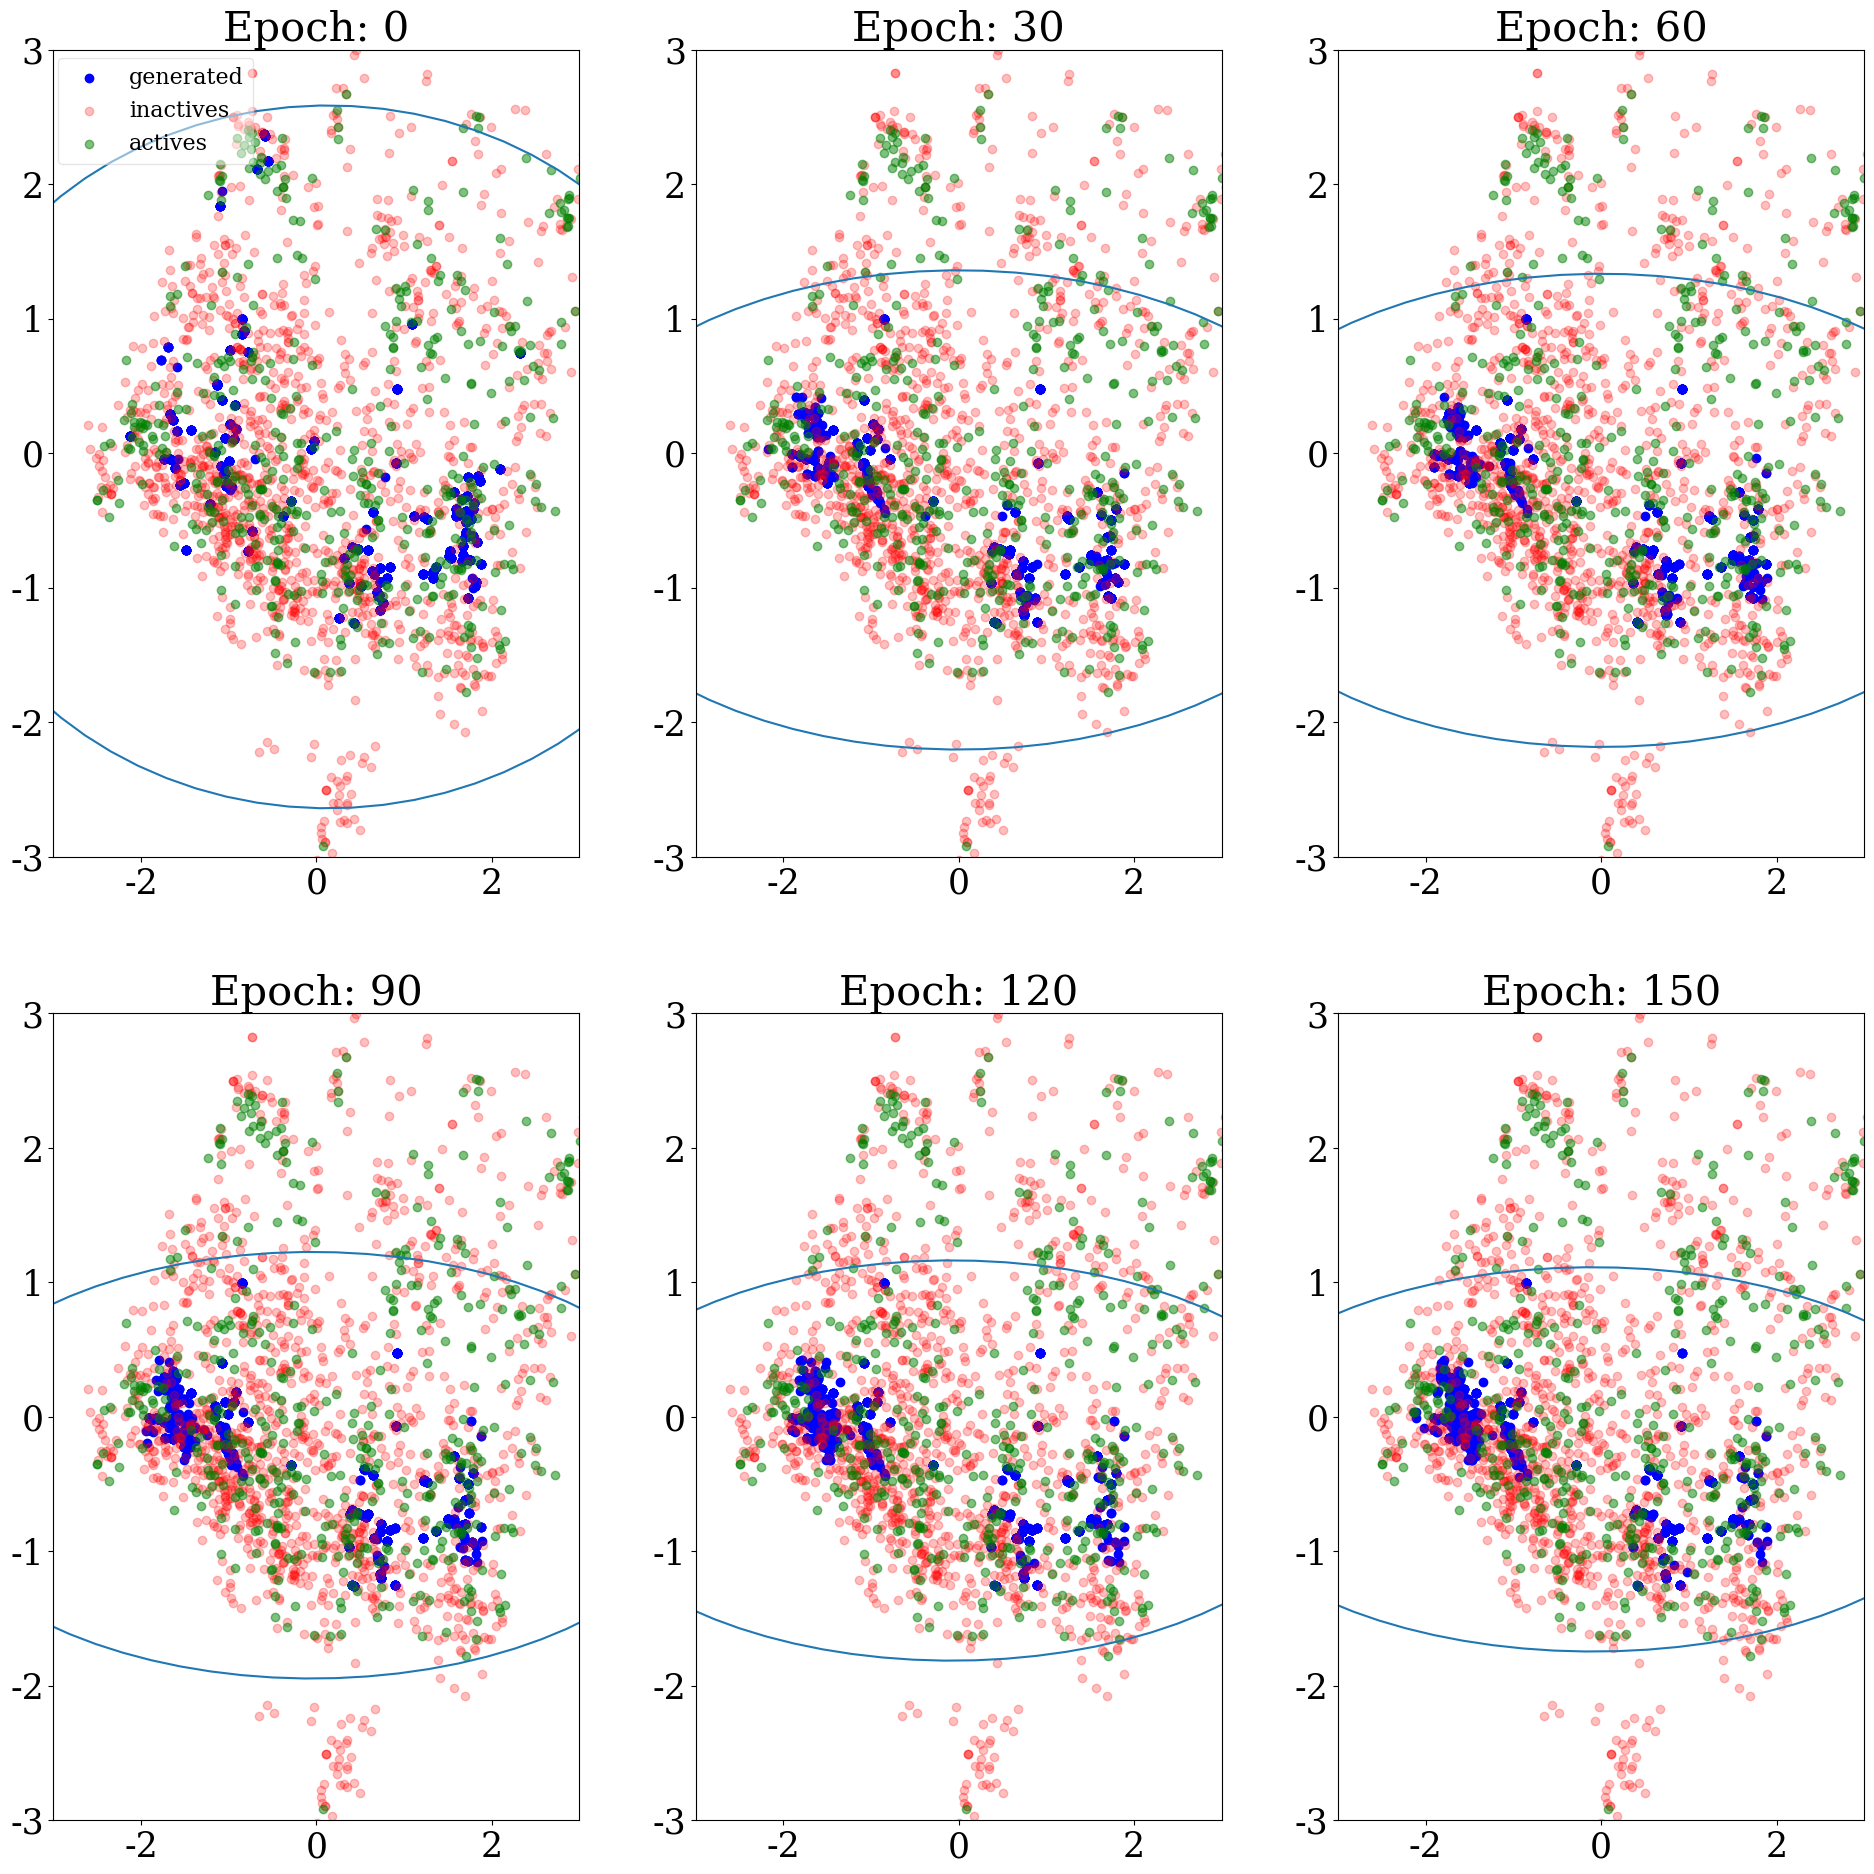

In [22]:
runs_to_display = runs
# runs_to_display = runs
fig, axs = plt.subplots(
    figsize=(20, 20), nrows=max(1, math.ceil(len(runs_to_display) / 3)), ncols=3
)
# suptitle_tmp = 'AD : ' + runs_to_display[0].split('_beta_ ')[0] + '- Effect of beta'
# fig.suptitle(suptitle_tmp, fontsize=30)


for i, run in enumerate(runs_to_display):
    index = runs.index(run)
    pca_gen = pca_generated[index]
    # For displaying the ellipse arounfd the main cluster
    [x_min, x_max] = [
        np.quantile(pca_gen[:, 0:1], quant),
        np.quantile(pca_gen[:, 0:1], 1.0 - quant),
    ]
    [y_min, y_max] = [
        np.quantile(pca_gen[:, 1:2], quant),
        np.quantile(pca_gen[:, 1:2], 1.0 - quant),
    ]
    center_x = np.mean([x_max, x_min])
    center_y = np.mean([y_max, y_min])
    radius_x = l * (x_max - x_min)
    radius_y = l * (y_max - y_min)
    #
    ax = axs.flatten()[i]
    int_diversity = round(int_diversity_generated[index], 2)
    run_title = f"$\lambda$={run} ({int_diversity})"
    ax.set_title(run_title.replace("_", " "), fontsize=30)
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_gen[:, 0], pca_gen[:, 1], c="b", label="generated", alpha=1)
    ax.scatter(
        pca_inactive[:, 0], pca_inactive[:, 1], c="r", label="inactives", alpha=0.25
    )
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c="g", label="actives", alpha=0.5)
    # Proximity ellipse
    ax.plot(center_x + radius_x * np.cos(t), center_y + radius_y * np.sin(t))
    #
    ax.tick_params(axis="both", which="major", labelsize=25)
    ax.tick_params(axis="both", which="minor", labelsize=25)
    handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.055, 0.945), ncol=1, fancybox=True, shadow=False, framealpha=0.5, fontsize=16)
fig.tight_layout(pad=1.5)
plt.savefig("graphs/DRD2_lambda_0_evolution.pdf", dpi=300)